# Feb 7th, 2022 (Structural Connectome)

**Motivation**: Hierarchical clustering on <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
sys.path.insert(0, pjoin(git_dir, 'mouse_connectivity_models'))

In [3]:
from mcmodels.core import VoxelModelCache
cache = VoxelModelCache(manifest_file='connectivity/voxel_model_manifest.json')
print(cache.to_json())

{
  "resolution": 100,
  "cache": true,
  "manifest_file": "connectivity/voxel_model_manifest.json",
  "ccf_version": "annotation/ccf_2017",
  "base_uri": null,
  "version": 1.3
}

In [4]:
voxel_array, source_mask, target_mask = cache.get_voxel_connectivity_array()
voxel_array

VoxelConnectivityArray(dtype=float64, shape=(226346, 448962))

In [5]:
# some given source/target voxels
source, target = 20353, 68902

# we index the VoxelConnectivyArray object just like it is a numpy ndarray
connection_strength = voxel_array[source, target]

# a row would be the bi-lateral connection strength from a given voxel
row = voxel_array[source]

# a column would be the connection strength to a given voxel
# from each voxel in the right hemisphere
column = voxel_array[:, target]

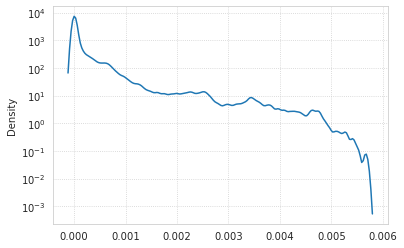

In [6]:
sns.kdeplot(row[row.nonzero()])
plt.yscale('log')

## Parc

In [7]:
mice = Mice(128)
cortex = mice.parcel['cortex']
regions = cortex[cortex.nonzero()]
regions = np.unique(regions)
hcl = mice.parcel.decode(regions)

regions_r = mice.parcel.encode(hcl[hcl[:, 0] == 2])
cortex_r = dc(cortex)
cortex_r[~np.isin(cortex, regions_r)] = 0

len(regions), len(regions_r), cortex.shape

(768, 384, (132, 80, 114))

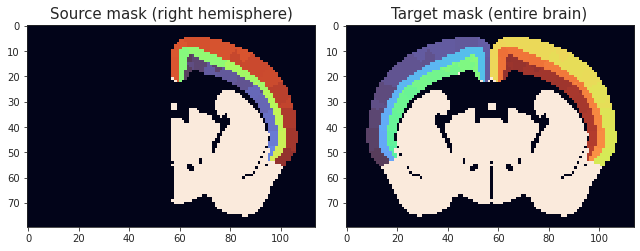

In [8]:
fig, axes = create_figure(1, 2, (9, 5))

slice_i = 60

axes[0].imshow(source_mask.mask[slice_i])
axes[1].imshow(target_mask.mask[slice_i])

axes[0].set_title('Source mask (right hemisphere)', fontsize=15)
axes[1].set_title('Target mask (entire brain)', fontsize=15)

x2plt = cortex_r[slice_i]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
axes[0].imshow(x2plt, alpha=0.8, cmap='turbo_r')
x2plt = cortex[slice_i]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
axes[1].imshow(x2plt, alpha=0.8, cmap='turbo')

plt.show()

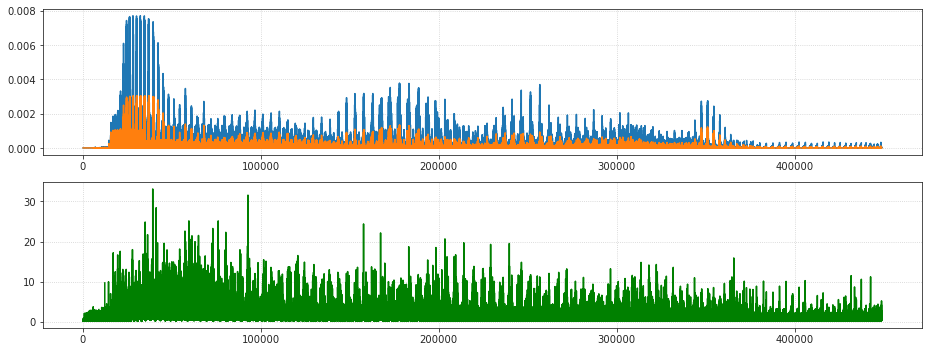

In [9]:
src_ids = np.where(source_mask.mask_volume(cortex == 385))[0]
row = voxel_array[src_ids]
mu = row.mean(0)
sd = row.std(0)

fig, axes = create_figure(2, 1, (13, 5))
axes[0].plot(mu)
axes[0].plot(sd)
axes[1].plot(mu / sd, color='g')
add_grid(axes)
plt.show()

In [10]:
%%time

rows = np.zeros((len(regions_r), *target_mask.masked_shape))
for i, idx in tqdm(enumerate(regions_r), total=len(regions_r)):
    src_ids = np.where(source_mask.mask_volume(cortex == idx))[0]
    rows[i] = voxel_array[src_ids].mean(0)

  0%|          | 0/384 [00:00<?, ?it/s]

CPU times: user 51min 19s, sys: 1min 31s, total: 52min 50s
Wall time: 3min 22s


In [21]:
i = 60
regions_r[i], regions_r[i + 128]

(445, 573)

In [22]:
mice.parcel.decode(regions_r)[[i, i + 128]]

array([[ 2, 61,  0],
       [ 2, 61,  1]])

In [23]:
np.min(rows[i]), np.max(rows[i])

(0.0, 0.0030662421418707485)

In [24]:
thres = 1e-13
out = np.zeros(target_mask.mask.shape)
for j, coo in enumerate(target_mask.coordinates):
    if rows[0, j] < thres:
        continue
    coo_flat = np.ravel_multi_index(coo, out.shape)
    out.flat[coo_flat] = rows[i, j]

In [25]:
template = mice.al.mcc.get_template_volume()[0]

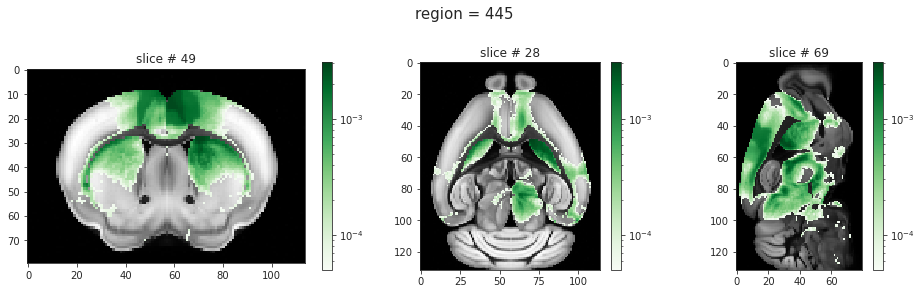

In [26]:
fig, axes = create_figure(1, 3, (13, 4), width_ratios=[1.6, 1.05, 1])
slices = np.unravel_index(np.argmax(out), out.shape)
for j, ax in enumerate(axes.flat):
    s = slices[j]
    ax.imshow(np.take(template, s, j), cmap='Greys_r')
    x2plt = np.take(out, s, j)
    x2plt = np.ma.masked_where(x2plt < 5e-5, x2plt)

    im = ax.imshow(x2plt, cmap='Greens', norm=matplotlib.colors.LogNorm())
    plt.colorbar(im, ax=ax)
    ax.set_title(f'slice # {s}')
fig.suptitle(f"region = {regions_r[i]}", fontsize=15, y=1.01)
plt.show()

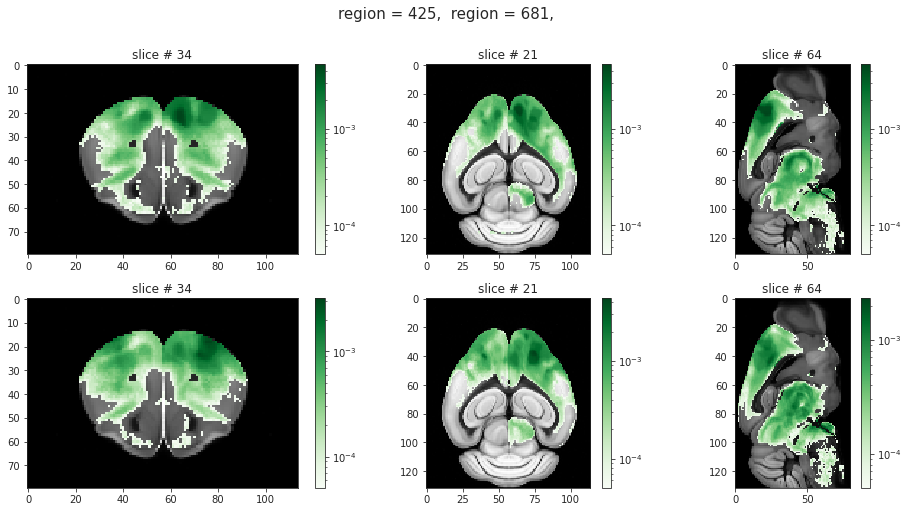

In [27]:
msg = ''
fig, axes = create_figure(2, 3, (13, 7), width_ratios=[1.6, 1.05, 1])
slices = None

for ii, i in enumerate([40, 40 + 128 + 128]):
    thres = 1e-13
    out = np.zeros(target_mask.mask.shape)
    for j, coo in enumerate(target_mask.coordinates):
        if rows[0, j] < thres:
            continue
        coo_flat = np.ravel_multi_index(coo, out.shape)
        out.flat[coo_flat] = rows[i, j]

    slices = slices if slices else np.unravel_index(np.argmax(out), out.shape)
    for j, ax in enumerate(axes[ii].flat):
        s = slices[j]
        ax.imshow(np.take(template, s, j), cmap='Greys_r')
        x2plt = np.take(out, s, j)
        x2plt = np.ma.masked_where(x2plt < 5e-5, x2plt)

        im = ax.imshow(x2plt, cmap='Greens', norm=matplotlib.colors.LogNorm())
        plt.colorbar(im, ax=ax)
        ax.set_title(f'slice # {s}')
    msg += f"region = {regions_r[i]},  "
fig.suptitle(msg, fontsize=15, y=1.01)
plt.show()

In [28]:
mice.parcel.decode([425, 681])

array([[ 2, 41,  0],
       [ 2, 41,  2]])

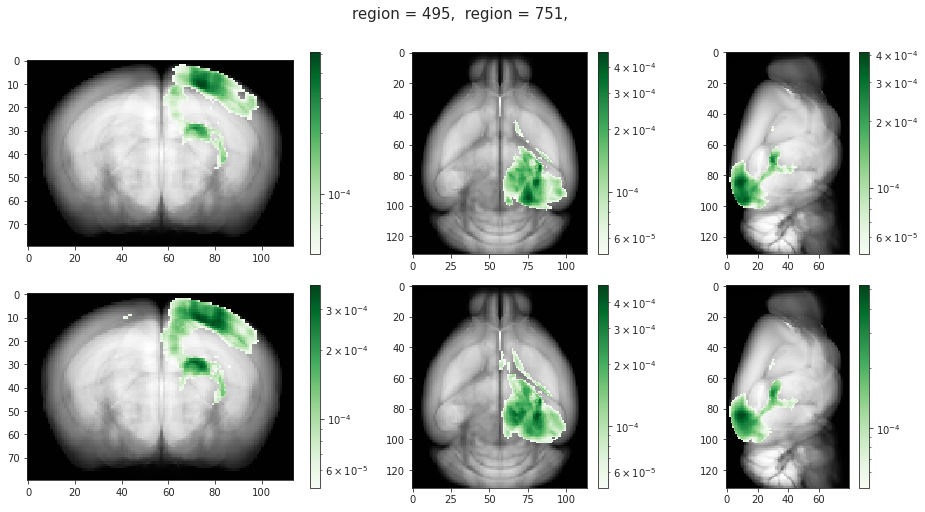

In [29]:
msg = ''
fig, axes = create_figure(2, 3, (13, 7), width_ratios=[1.6, 1.05, 1])

for ii, i in enumerate([110, 110 + 128 + 128]):
    thres = 1e-13
    out = np.zeros(target_mask.mask.shape)
    for j, coo in enumerate(target_mask.coordinates):
        if rows[0, j] < thres:
            continue
        coo_flat = np.ravel_multi_index(coo, out.shape)
        out.flat[coo_flat] = rows[i, j]

    for j, ax in enumerate(axes[ii].flat):
        ax.imshow(np.mean(template, j), cmap='Greys_r')
        x2plt = np.mean(out, j)
        x2plt = np.ma.masked_where(x2plt < 5e-5, x2plt)

        im = ax.imshow(x2plt, cmap='Greens', norm=matplotlib.colors.LogNorm())
        plt.colorbar(im, ax=ax)
    msg += f"region = {regions_r[i]},  "
fig.suptitle(msg, fontsize=15, y=1.01)
plt.show()

In [30]:
mice.parcel.decode([495, 751])

array([[  2, 111,   0],
       [  2, 111,   2]])

## Hier

In [31]:
rows.shape

(384, 448962)

In [32]:
hcl = mice.parcel.decode(regions_r)

In [33]:
i = 110
hcl[i], hcl[i + 2 * 128]

(array([  2, 111,   0]), array([  2, 111,   2]))

[<matplotlib.lines.Line2D object at 0x7fdea12b9370>]

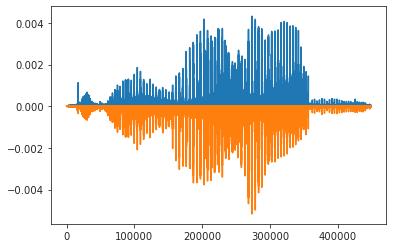

In [34]:
plt.plot(rows[i])
plt.plot(-rows[i + 2* 128])

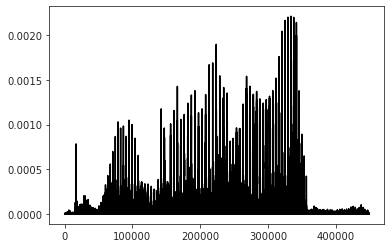

In [35]:
delta = np.abs(rows[i] - rows[i + 2 * 128])
plt.plot(delta, color='k')
plt.show()

In [36]:
rho, pval = sp_stats.spearmanr(rows.T)

In [37]:
d = 1 - rho
d = (d + d.T) / 2
np.fill_diagonal(d, 0.)
d.shape, rho.shape, pval.shape

((384, 384), (384, 384), (384, 384))

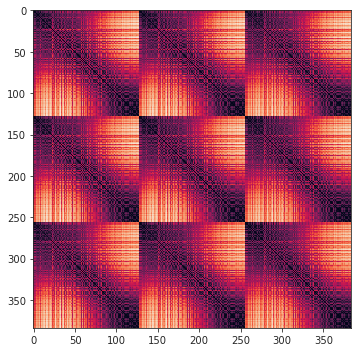

In [38]:
fig, ax = create_figure(figsize=(6, 5))
ax.imshow(d);

In [39]:
from analysis.hierarchical import get_clust_graph, sp_hier
z = sp_hier.linkage(
    sp_dist.squareform(d),
    method='ward',
    metric='correlation',
    optimal_ordering=True,
)

In [40]:
num_clusters = 5

result = get_clust_graph(
    linkage_mat=z,
    labels=regions_r,
    num_clusters=num_clusters,
)

In [41]:
base = Base(mice, num_clusters, mode='bold-ctx')

In [42]:
comm_vec = np.zeros(len(base.n2l))
for c_idx, clist in result['cluster_assigns'].items():
    hcl = mice.parcel.decode(clist)
    hcl[:, 0] = 1
    members = mice.parcel.encode(hcl).tolist() + clist
    hcl = mice.parcel.decode(members)
    for hh, cc, ll in hcl:
        lbl = f"{hh}-{cc}-{ll}"
        try:
            comm_vec[base.l2n[lbl]] = c_idx
        except KeyError:
            continue
comm_vec = comm_vec.astype(int)

In [43]:
np.unique(comm_vec)

array([1, 2, 3, 4, 5])

In [44]:
pi_disjoint = np.zeros((num_clusters, len(comm_vec)))
for i, c in enumerate(comm_vec):
    pi_disjoint[c - 1, i] = 1

In [45]:
mapping = base.align_centroid_to_structs(pi_disjoint)
pi_disjoint = pi_disjoint[mapping]

In [46]:
partition = np.argmax(pi_disjoint, 0) + 1
proj = base.project_vec(partition, layer=0, add_disjoint=False)

<matplotlib.image.AxesImage object at 0x7fde8c1ee9d0>

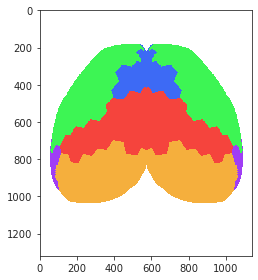

In [47]:
x2plt = proj['top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)

fig, ax = create_figure()
plt.imshow(x2plt, cmap=base.cmaps[-1])

<matplotlib.image.AxesImage object at 0x7fde9c38caf0>

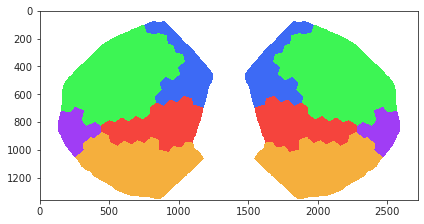

In [48]:
x2plt = proj['flat'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)

fig, ax = create_figure()
plt.imshow(x2plt, cmap=base.cmaps[-1])

In [49]:
num_clusters = range(2, 24)

tr_all = {}
cmap_all = {}
partition_all = {}


for k in tqdm(num_clusters):
    base = Base(mice, k, mode='bold-ctx')
    cmap_all[k] = base.cmaps[-1]
    
    result = get_clust_graph(
        linkage_mat=z,
        labels=regions_r,
        num_clusters=k,
    )
    
    comm_vec = np.zeros(len(base.n2l))
    for c_idx, clist in result['cluster_assigns'].items():
        hcl = mice.parcel.decode(clist)
        hcl[:, 0] = 1
        members = mice.parcel.encode(hcl).tolist() + clist
        hcl = mice.parcel.decode(members)
        for hh, cc, ll in hcl:
            lbl = f"{hh}-{cc}-{ll}"
            try:
                comm_vec[base.l2n[lbl]] = c_idx
            except KeyError:
                continue
    comm_vec = comm_vec.astype(int)
    
    pi_disjoint = np.zeros((k, len(comm_vec)))
    for i, c in enumerate(comm_vec):
        pi_disjoint[c - 1, i] = 1

    mapping = base.align_centroid_to_structs(pi_disjoint)
    pi_disjoint = pi_disjoint[mapping]

    partition = np.argmax(pi_disjoint, 0) + 1
    proj = base.project_vec(partition, layer=0, add_disjoint=False)
    
    partition_all[k] = partition
    tr_all[k] = base.trim2d(proj)

  0%|          | 0/22 [00:00<?, ?it/s]

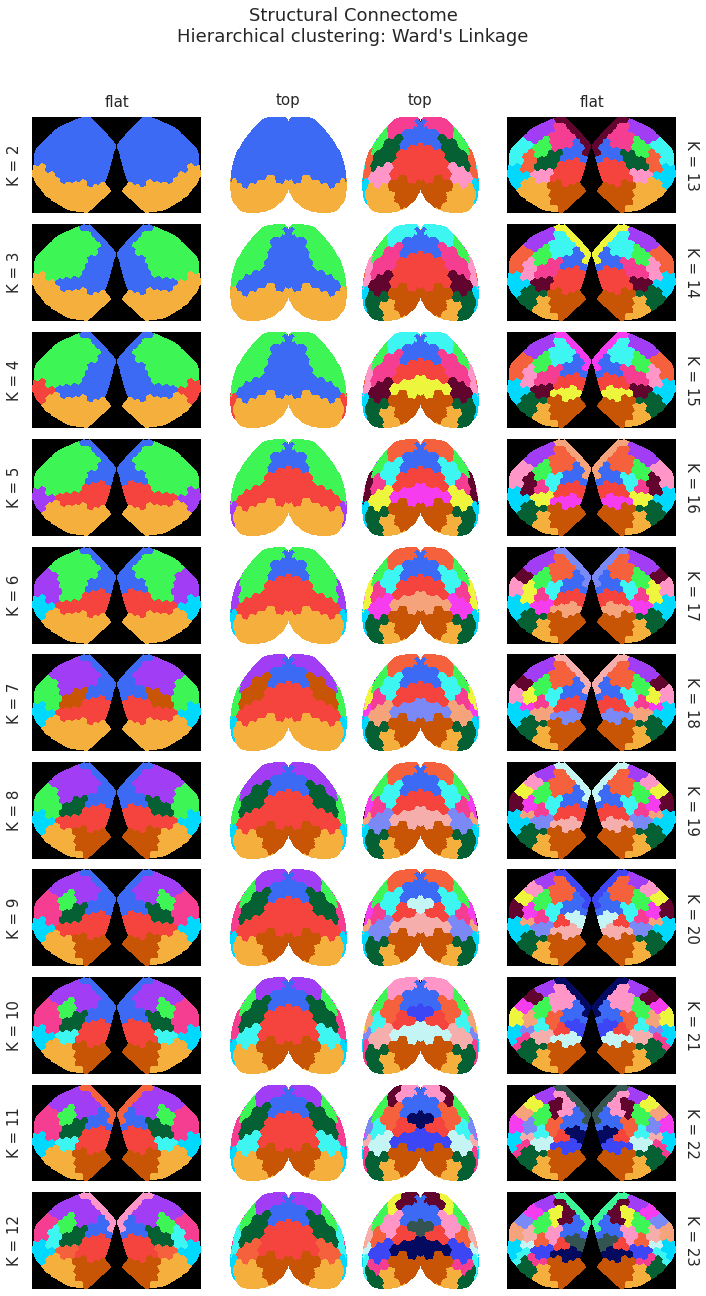

In [51]:
min_thres = 0.01

labels = ('SC', 'SC2')

ncols = 4
nrows = len(num_clusters) // 2
fig, axes = create_figure(
    nrows=nrows, ncols=ncols,
    figsize=(10.0, 1.6 * nrows),
    width_ratios=[1.6, 1, 1, 1.6],
    style='white',
)

cmap_anat = 'Greys_r'

for ii, k in enumerate(num_clusters):
    i = ii % nrows
    x_top = tr_all[k]['proj-top'][0]
    x_flat = tr_all[k]['proj-flat'][0]

    cmap = get_cluster_cmap(range(k))
    interp = 'none'

    if ii < nrows:
        j_top = 1
        j_flat = 0
        axes[i, j_flat].set_ylabel(f'K = {k}', fontsize=15, labelpad=10)
    else:
        j_top = 2
        j_flat = 3
        axes[i, j_flat].set_ylabel(f'K = {k}', fontsize=15, labelpad=23, rotation=-90)
        axes[i, j_flat].yaxis.set_label_position("right")
        # axes[i, j_flat].yaxis.tick_right()
        #axtw = axes[i, j_flat].twinx()
        #axtw.set_ylabel(f'K = {k}', fontsize=15, rotation=-90, labelpad=20)
        #axtw.yaxis.set_label_position("right")
        #axtw.set_yticks([])

    axes[i, j_flat].imshow(tr_all[k]['flat'], cmap=cmap_anat)
    x2plt = np.ma.masked_where(x_flat < min_thres, x_flat)
    im = axes[i, j_flat].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = np.ma.masked_where(
        tr_all[k]['top'] == 0, tr_all[k]['top'])
    axes[i, j_top].imshow(x2plt, cmap=cmap_anat)
    x2plt = np.ma.masked_where(x_top < min_thres, x_top)
    axes[i, j_top].imshow(x2plt, cmap=cmap, interpolation=interp)

axes[0, 0].set_title('flat', fontsize=15, y=1.04)
axes[0, 1].set_title('top', fontsize=15, y=1.06)
axes[0, 2].set_title('top', fontsize=15, y=1.06)
axes[0, 3].set_title('flat', fontsize=15, y=1.04)

remove_ticks(axes)
sup = fig.suptitle("Structural Connectome\nHierarchical clustering: Ward's Linkage", fontsize=18, y=1.02)
fig.savefig(pjoin(tmp_dir, 'SC_hier_128.pdf'), bbox_inches='tight')
fig.savefig(pjoin(tmp_dir, 'SC_hier_128.png'), bbox_inches='tight', dpi=100)
plt.show()

### Optical subset only

In [60]:
len(mice.node_lookup['ca2']) // 2

87

In [61]:
optical = []
hcl = mice.parcel.decode(regions_r)
for i, (hh, cc, ll) in enumerate(hcl):
    if f"{hh}-{cc}-{ll}" in mice.node_lookup['ca2'].values():
        optical.append(i)
len(optical)

87

In [65]:
d_optical = d[optical][:, optical]
d_optical.shape

(87, 87)

<matplotlib.image.AxesImage object at 0x7fde068d5a90>

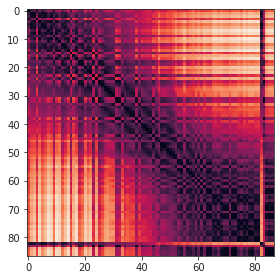

In [71]:
fig, ax = create_figure()
plt.imshow(d_optical)

In [72]:
from analysis.hierarchical import get_clust_graph, sp_hier
z = sp_hier.linkage(
    sp_dist.squareform(d_optical),
    method='ward',
    metric='correlation',
    optimal_ordering=True,
)

In [74]:
num_clusters = 5

result = get_clust_graph(
    linkage_mat=z,
    labels=regions_r[optical],
    num_clusters=num_clusters,
)

In [75]:
base = Base(mice, num_clusters, mode='bold-lite')

In [76]:
comm_vec = np.zeros(len(base.n2l))
for c_idx, clist in result['cluster_assigns'].items():
    hcl = mice.parcel.decode(clist)
    hcl[:, 0] = 1
    members = mice.parcel.encode(hcl).tolist() + clist
    hcl = mice.parcel.decode(members)
    for hh, cc, ll in hcl:
        lbl = f"{hh}-{cc}-{ll}"
        try:
            comm_vec[base.l2n[lbl]] = c_idx
        except KeyError:
            continue
comm_vec = comm_vec.astype(int)

In [77]:
np.unique(comm_vec)

array([1, 2, 3, 4, 5])

In [78]:
pi_disjoint = np.zeros((num_clusters, len(comm_vec)))
for i, c in enumerate(comm_vec):
    pi_disjoint[c - 1, i] = 1

In [79]:
mapping = base.align_centroid_to_structs(pi_disjoint)
pi_disjoint = pi_disjoint[mapping]

In [80]:
partition = np.argmax(pi_disjoint, 0) + 1
proj = base.project_vec(partition, layer=0, add_disjoint=False)

<matplotlib.image.AxesImage object at 0x7fdb30e43a90>

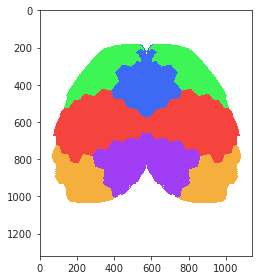

In [81]:
x2plt = proj['top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)

fig, ax = create_figure()
plt.imshow(x2plt, cmap=base.cmaps[-1])

<matplotlib.image.AxesImage object at 0x7fdb30dd4940>

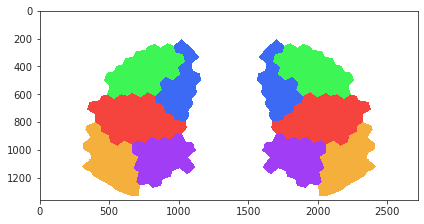

In [82]:
x2plt = proj['flat'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)

fig, ax = create_figure()
plt.imshow(x2plt, cmap=base.cmaps[-1])

In [84]:
num_clusters = range(2, 24)

tr_all = {}
cmap_all = {}
partition_all = {}


for k in tqdm(num_clusters):
    base = Base(mice, k, mode='bold-lite')
    cmap_all[k] = base.cmaps[-1]
    
    result = get_clust_graph(
        linkage_mat=z,
        labels=regions_r[optical],
        num_clusters=k,
    )
    
    comm_vec = np.zeros(len(base.n2l))
    for c_idx, clist in result['cluster_assigns'].items():
        hcl = mice.parcel.decode(clist)
        hcl[:, 0] = 1
        members = mice.parcel.encode(hcl).tolist() + clist
        hcl = mice.parcel.decode(members)
        for hh, cc, ll in hcl:
            lbl = f"{hh}-{cc}-{ll}"
            try:
                comm_vec[base.l2n[lbl]] = c_idx
            except KeyError:
                continue
    comm_vec = comm_vec.astype(int)
    
    pi_disjoint = np.zeros((k, len(comm_vec)))
    for i, c in enumerate(comm_vec):
        pi_disjoint[c - 1, i] = 1

    mapping = base.align_centroid_to_structs(pi_disjoint)
    pi_disjoint = pi_disjoint[mapping]

    partition = np.argmax(pi_disjoint, 0) + 1
    proj = base.project_vec(partition, layer=0, add_disjoint=False)
    
    partition_all[k] = partition
    tr_all[k] = base.trim2d(proj)

  0%|          | 0/22 [00:00<?, ?it/s]

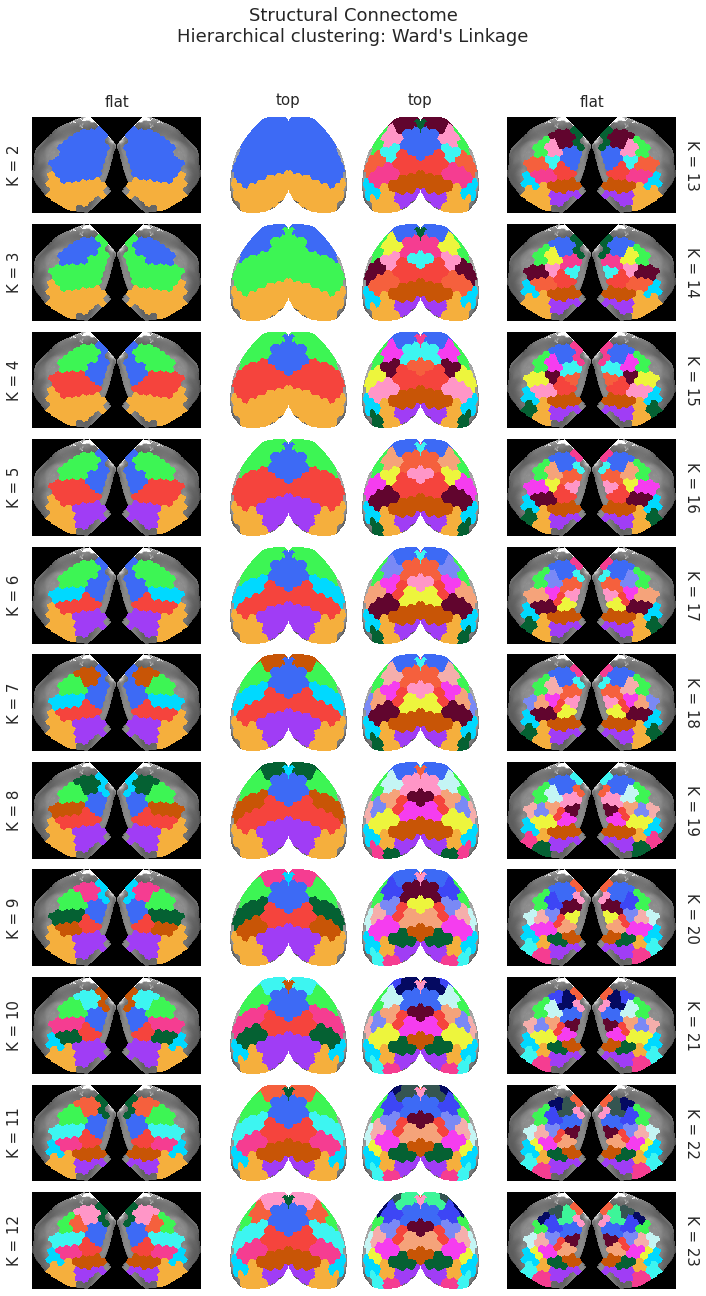

In [85]:
min_thres = 0.01

labels = ('SC', 'SC2')

ncols = 4
nrows = len(num_clusters) // 2
fig, axes = create_figure(
    nrows=nrows, ncols=ncols,
    figsize=(10.0, 1.6 * nrows),
    width_ratios=[1.6, 1, 1, 1.6],
    style='white',
)

cmap_anat = 'Greys_r'

for ii, k in enumerate(num_clusters):
    i = ii % nrows
    x_top = tr_all[k]['proj-top'][0]
    x_flat = tr_all[k]['proj-flat'][0]

    cmap = get_cluster_cmap(range(k))
    interp = 'none'

    if ii < nrows:
        j_top = 1
        j_flat = 0
        axes[i, j_flat].set_ylabel(f'K = {k}', fontsize=15, labelpad=10)
    else:
        j_top = 2
        j_flat = 3
        axes[i, j_flat].set_ylabel(f'K = {k}', fontsize=15, labelpad=23, rotation=-90)
        axes[i, j_flat].yaxis.set_label_position("right")
        # axes[i, j_flat].yaxis.tick_right()
        #axtw = axes[i, j_flat].twinx()
        #axtw.set_ylabel(f'K = {k}', fontsize=15, rotation=-90, labelpad=20)
        #axtw.yaxis.set_label_position("right")
        #axtw.set_yticks([])

    axes[i, j_flat].imshow(tr_all[k]['flat'], cmap=cmap_anat)
    x2plt = np.ma.masked_where(x_flat < min_thres, x_flat)
    im = axes[i, j_flat].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = np.ma.masked_where(
        tr_all[k]['top'] == 0, tr_all[k]['top'])
    axes[i, j_top].imshow(x2plt, cmap=cmap_anat)
    x2plt = np.ma.masked_where(x_top < min_thres, x_top)
    axes[i, j_top].imshow(x2plt, cmap=cmap, interpolation=interp)

axes[0, 0].set_title('flat', fontsize=15, y=1.04)
axes[0, 1].set_title('top', fontsize=15, y=1.06)
axes[0, 2].set_title('top', fontsize=15, y=1.06)
axes[0, 3].set_title('flat', fontsize=15, y=1.04)

remove_ticks(axes)
sup = fig.suptitle("Structural Connectome\nHierarchical clustering: Ward's Linkage", fontsize=18, y=1.02)
fig.savefig(pjoin(tmp_dir, 'SC_hier_optical_128.pdf'), bbox_inches='tight')
fig.savefig(pjoin(tmp_dir, 'SC_hier_optical_128.png'), bbox_inches='tight', dpi=100)
plt.show()

## What about 256

In [186]:
mice = Mice(256)
cortex = mice.parcel['cortex']
regions = cortex[cortex.nonzero()]
regions = np.unique(regions)
hcl = mice.parcel.decode(regions)

regions_r = mice.parcel.encode(hcl[hcl[:, 0] == 2])
cortex_r = dc(cortex)
cortex_r[~np.isin(cortex, regions_r)] = 0

len(regions), len(regions_r), cortex.shape

(1536, 768, (132, 80, 114))

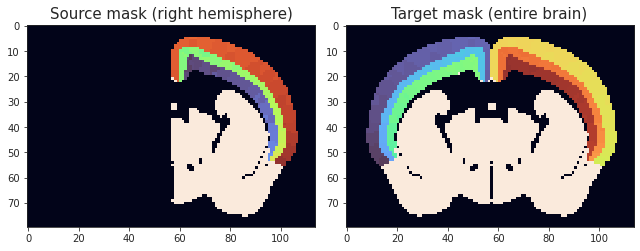

In [187]:
fig, axes = create_figure(1, 2, (9, 5))

slice_i = 60

axes[0].imshow(source_mask.mask[slice_i])
axes[1].imshow(target_mask.mask[slice_i])

axes[0].set_title('Source mask (right hemisphere)', fontsize=15)
axes[1].set_title('Target mask (entire brain)', fontsize=15)

x2plt = cortex_r[slice_i]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
axes[0].imshow(x2plt, alpha=0.8, cmap='turbo_r')
x2plt = cortex[slice_i]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)
axes[1].imshow(x2plt, alpha=0.8, cmap='turbo')

plt.show()

In [188]:
%%time

rows = np.zeros((len(regions_r), *target_mask.masked_shape))
for i, idx in tqdm(enumerate(regions_r), total=len(regions_r)):
    src_ids = source_mask.mask_volume(cortex == idx)
    rows[i] = voxel_array[src_ids].mean(0)

  0%|          | 0/768 [00:00<?, ?it/s]

CPU times: user 52min 58s, sys: 37 s, total: 53min 35s
Wall time: 2min 43s


In [189]:
rho, pval = sp_stats.spearmanr(rows.T)

In [190]:
d = 1 - rho
d = (d + d.T) / 2
np.fill_diagonal(d, 0.)
d.shape, rho.shape, pval.shape

((768, 768), (768, 768), (768, 768))

In [191]:
from analysis.hierarchical import get_clust_graph, sp_hier
z = sp_hier.linkage(
    sp_dist.squareform(d),
    method='ward',
    metric='correlation',
    optimal_ordering=True,
)

In [192]:
num_clusters = range(2, 24)

tr_all = {}
cmap_all = {}
partition_all = {}


for k in tqdm(num_clusters):
    base = Base(mice, k, mode='bold-ctx', prep_data=False)
    cmap_all[k] = base.cmaps[-1]
    
    result = get_clust_graph(
        linkage_mat=z,
        labels=regions_r,
        num_clusters=k,
    )
    
    comm_vec = np.zeros(len(base.n2l))
    for c_idx, clist in result['cluster_assigns'].items():
        hcl = mice.parcel.decode(clist)
        hcl[:, 0] = 1
        members = mice.parcel.encode(hcl).tolist() + clist
        hcl = mice.parcel.decode(members)
        for hh, cc, ll in hcl:
            lbl = f"{hh}-{cc}-{ll}"
            try:
                comm_vec[base.l2n[lbl]] = c_idx
            except KeyError:
                continue
    comm_vec = comm_vec.astype(int)
    
    pi_disjoint = np.zeros((k, len(comm_vec)))
    for i, c in enumerate(comm_vec):
        pi_disjoint[c - 1, i] = 1

    mapping = base.align_centroid_to_structs(pi_disjoint)
    pi_disjoint = pi_disjoint[mapping]

    partition = np.argmax(pi_disjoint, 0) + 1
    proj = base.project_vec(partition, layer=0, add_disjoint=False)
    
    partition_all[k] = partition
    tr_all[k] = base.trim2d(proj)

  0%|          | 0/22 [00:00<?, ?it/s]

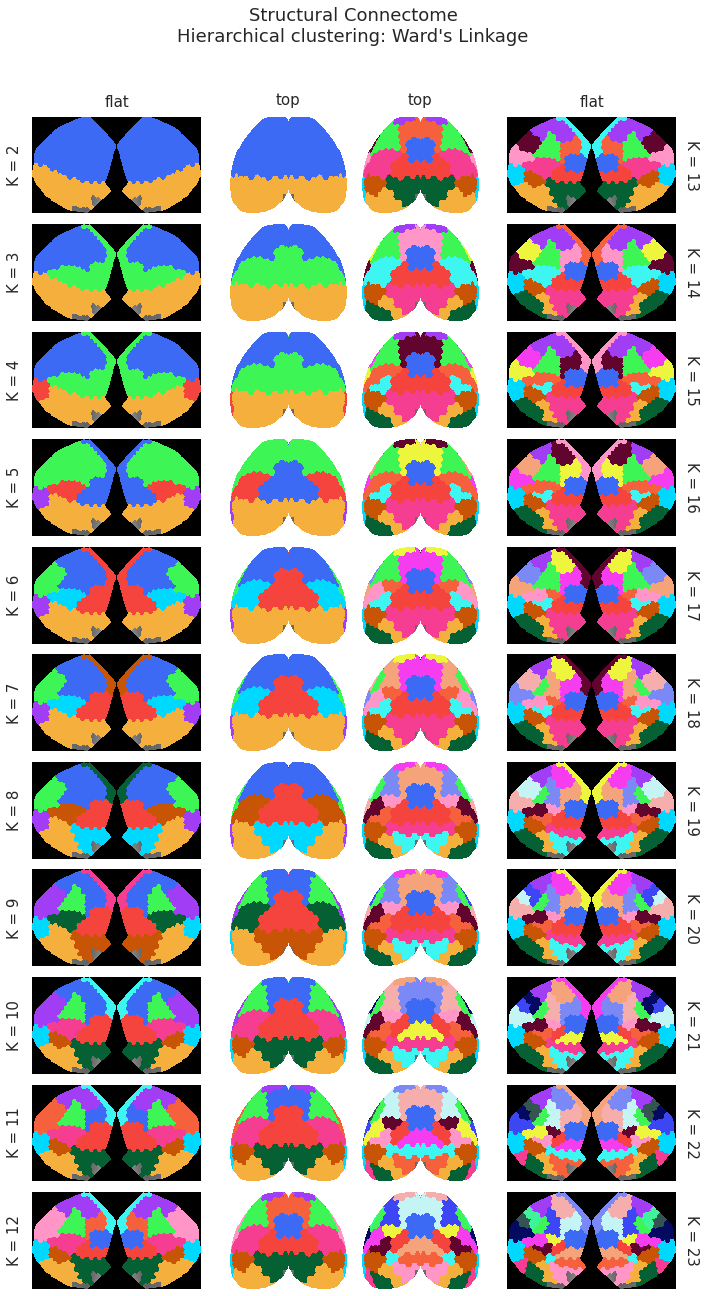

In [193]:
min_thres = 0.01

labels = ('SC', 'SC2')

ncols = 4
nrows = len(num_clusters) // 2
fig, axes = create_figure(
    nrows=nrows, ncols=ncols,
    figsize=(10.0, 1.6 * nrows),
    width_ratios=[1.6, 1, 1, 1.6],
    style='white',
)

cmap_anat = 'Greys_r'

for ii, k in enumerate(num_clusters):
    i = ii % nrows
    x_top = tr_all[k]['proj-top'][0]
    x_flat = tr_all[k]['proj-flat'][0]

    cmap = get_cluster_cmap(range(k))
    #ylbl = 'Disjoint\n'
    #interp = 'none'

    if ii < nrows:
        j_top = 1
        j_flat = 0
        axes[i, j_flat].set_ylabel(f'K = {k}', fontsize=15, labelpad=10)
    else:
        j_top = 2
        j_flat = 3
        axes[i, j_flat].set_ylabel(f'K = {k}', fontsize=15, labelpad=23, rotation=-90)
        axes[i, j_flat].yaxis.set_label_position("right")
        # axes[i, j_flat].yaxis.tick_right()
        #axtw = axes[i, j_flat].twinx()
        #axtw.set_ylabel(f'K = {k}', fontsize=15, rotation=-90, labelpad=20)
        #axtw.yaxis.set_label_position("right")
        #axtw.set_yticks([])

    axes[i, j_flat].imshow(tr_all[k]['flat'], cmap=cmap_anat)
    x2plt = np.ma.masked_where(x_flat < min_thres, x_flat)
    im = axes[i, j_flat].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = np.ma.masked_where(
        tr_all[k]['top'] == 0, tr_all[k]['top'])
    axes[i, j_top].imshow(x2plt, cmap=cmap_anat)
    x2plt = np.ma.masked_where(x_top < min_thres, x_top)
    axes[i, j_top].imshow(x2plt, cmap=cmap, interpolation=interp)

axes[0, 0].set_title('flat', fontsize=15, y=1.04)
axes[0, 1].set_title('top', fontsize=15, y=1.06)
axes[0, 2].set_title('top', fontsize=15, y=1.06)
axes[0, 3].set_title('flat', fontsize=15, y=1.04)

remove_ticks(axes)
sup = fig.suptitle("Structural Connectome\nHierarchical clustering: Ward's Linkage", fontsize=18, y=1.02)
fig.savefig(pjoin(tmp_dir, 'SC_hier_256.pdf'), bbox_inches='tight')
fig.savefig(pjoin(tmp_dir, 'SC_hier_256.png'), bbox_inches='tight', dpi=100)
plt.show()